# Stock analysis

## Import

Libraries

In [1]:
from functions.init import *

from functions.analyse_price import *
from functions.params import index_tickers

## Get data

Run data

In [2]:
TICKER = 'ZIP'
first_end_of_quarter = '2020-06'
last_end_of_quarter = '2024-06'
historical_prices = {}

In [3]:
asx_companies_directory = pd.read_csv('../data/asx_companies_directory.csv')
asx_companies_directory['Market Cap'] = asx_companies_directory['Market Cap'].apply(
    lambda x: float(x) if x.isnumeric() else float(x.lower()) if 'E+' in x else np.nan)

In [4]:
gics = pd.read_csv('../data/asx_gics.csv')

# Define a dictionary mapping tickers to their corresponding sector and industry
updates = {
    'NWSLV.AX': {'Sector': 'Communication Services', 'Industry': 'Entertainment'},
    'KKC.AX': {'Sector': 'Financials', 'Industry': 'Diversified Financials'},
    'PCI.AX': {'Sector': 'Financials', 'Industry': 'Diversified Financials'},
    'RF1.AX': {'Sector': 'Financials', 'Industry': 'Investment Management'},
    'RG8.AX': {'Sector': 'Information Technology', 'Industry': 'Software'},
    'VG1.AX': {'Sector': 'Financials', 'Industry': 'Investment Management'},
    'WQG.AX': {'Sector': 'Financials', 'Industry': 'Investment Management'}
}

# Update the DataFrame based on the mapping
for ticker, data in updates.items():
    gics.loc[gics['Ticker'] == ticker, 'Sector'] = data['Sector']
    gics.loc[gics['Ticker'] == ticker, 'Industry'] = data['Industry']


gics['Industry'] = gics['Industry'].apply(lambda x: ''.join(
    str(x).split('-')).replace(' ', '').replace('—', ''))

gics['Sector'] = gics['Sector'].apply(lambda x: ''.join(
    str(x).split('-')).replace(' ', '').replace('—', ''))

In [5]:
# all companies in the top 500
top_500 = asx_companies_directory.sort_values(
    'Market Cap', ascending=False).head(500)['ASX code'].values + '.AX'

# get all companies with market cap above 1 billion
above_1b = asx_companies_directory[asx_companies_directory['Market Cap']
                                   >= 1000000000]['ASX code'].values + '.AX'

In [6]:
def find_similar_type_tickers(gics_type: str, gics_name: str, comparable_universe: list) -> list:
    same_gics_tickers = gics[(gics[gics_type] == gics_name) & (
        gics['Ticker'].isin(comparable_universe))]['Ticker'].values

    return same_gics_tickers

In [7]:
# find same industry stocks
ticker_gics_sector = gics[gics['Ticker'] == f'{TICKER}.AX']['Sector'].values[0]
ticker_gics_industry = gics[gics['Ticker']
                            == f'{TICKER}.AX']['Industry'].values[0]

In [8]:
same_sector_1bn = find_similar_type_tickers(
    gics_type='Sector', gics_name=ticker_gics_sector, comparable_universe=above_1b)
same_industry_1bn = find_similar_type_tickers(
    gics_type='Industry', gics_name=ticker_gics_industry, comparable_universe=above_1b)
same_sector_500 = find_similar_type_tickers(
    gics_type='Sector', gics_name=ticker_gics_sector, comparable_universe=top_500)
same_industry_500 = find_similar_type_tickers(
    gics_type='Industry', gics_name=ticker_gics_industry, comparable_universe=top_500)

In [9]:
comparable_tickers = {'type': 'same_industry_500', 'list': same_industry_500} if \
    (len(same_industry_500) > 1 or len(same_industry_500) == 1 and f'{TICKER}.AX' not in same_industry_500) \
    else {'type': 'same_sector_1bn', 'list': same_sector_1bn}

In [10]:
comparable_tickers['type']

'same_industry_500'

In [11]:
# get market caps and weight
same_industry_tickers_mcap = asx_companies_directory[((asx_companies_directory['ASX code']+'.AX').isin(
    comparable_tickers['list'])) & (asx_companies_directory['ASX code'] != TICKER)][['ASX code', 'Market Cap']]

# check for is integer
marketsame_industry_tickers_mcap_cap = same_industry_tickers_mcap[same_industry_tickers_mcap['Market Cap'].apply(
    lambda x: isinstance(x, float))]

# get weight
same_industry_tickers_mcap['weight'] = same_industry_tickers_mcap['Market Cap'] / \
    same_industry_tickers_mcap['Market Cap'].sum()

In [12]:
same_industry_tickers_mcap = same_industry_tickers_mcap.sort_values(
    by='Market Cap', ascending=False)
display(same_industry_tickers_mcap)

ticker_mv = asx_companies_directory[asx_companies_directory['ASX code'] == TICKER][[
    'ASX code', 'Market Cap']]
display(ticker_mv)

ticker_proportion_of_market = ticker_mv['Market Cap'].values[0] / \
    same_industry_tickers_mcap['Market Cap'].sum()
print(round(ticker_proportion_of_market, 2))

,ASX code,Market Cap,weight
1038,LFS,1.206025e+09,0.243995
391,CCP,1.085666e+09,0.219645
1037,LFG,1.053492e+09,0.213135
1417,PPM,5.951872e+08,0.120414
878,HUM,4.057027e+08,0.082079
1296,OBL,3.164943e+08,0.064031
1698,SVR,2.802649e+08,0.056701


,ASX code,Market Cap
1936,ZIP,3.420648e+09


0.69


In [13]:
ticker_mv['Market Cap'] = ticker_mv['Market Cap'].apply(
    lambda x: round(x/1e9, 2))
ticker_mv.rename(columns={'Market Cap': 'Market Cap ($bn)'}, inplace=True)

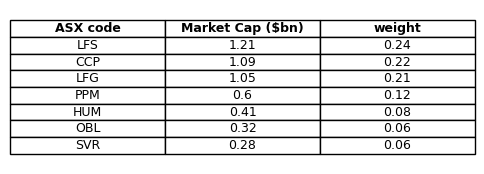

In [14]:
# Create the plot
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust figure size as needed
ax.axis('tight')
ax.axis('off')

same_industry_tickers_mcap['Market Cap'] = same_industry_tickers_mcap['Market Cap'].apply(
    lambda x: round(x/1e9, 2))
same_industry_tickers_mcap.rename(
    columns={'Market Cap': 'Market Cap ($bn)'}, inplace=True)
same_industry_tickers_mcap['weight'] = same_industry_tickers_mcap['weight'].apply(
    lambda x: round(x, 2))


# Create a table in the plot
table = ax.table(cellText=same_industry_tickers_mcap.values,
                 colLabels=same_industry_tickers_mcap.columns,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')


# Save the plot as an image
plt.savefig(f'../outputs/{TICKER}_same_industry_tickers_mcap_table.png',
            bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [15]:
same_gics_industry_weight_dict = same_industry_tickers_mcap.set_index('ASX code')[
    'weight'].to_dict()

In [16]:
# TODO:
my_portfolio_tickers = [TICKER]
my_portfolio_tickers.extend([ticker.split('.')[
                            0] for ticker in comparable_tickers['list'] if ticker.split('.')[0] != TICKER])
my_portfolio_tickers.extend(index_tickers)

historical_prices = get_historical_prices(
    my_portfolio_tickers, index_tickers, historical_prices)

$LFG.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$PPM.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$LFS.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$PPM.AX: possibly delisted; no price data found  (1d 2020-01-01 -> 2020-12-31) (Yahoo error = "Data doesn't exist for startDate = 1577797200, endDate = 1609333200")
$LFS.AX: possibly delisted; no price data found  (1d 2020-01-01 -> 2020-12-31) (Yahoo error = "Data doesn't exist for startDate = 1577797200, endDate = 1609333200")


In [17]:
monthly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    monthly_returns_df_dict[ticker] = get_return(price_df, 'M')

quarterly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    quarterly_returns_df_dict[ticker] = get_return(price_df, 'Q')

yearly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    yearly_returns_df_dict[ticker] = get_return(price_df, 'Y')

In [18]:
monthly_returns_df_dict = get_gics_industry_weighted_mean(
    monthly_returns_df_dict, TICKER, my_portfolio_tickers, same_gics_industry_weight_dict, index_tickers, 'M', comparable_tickers=comparable_tickers)
quarterly_returns_df_dict = get_gics_industry_weighted_mean(
    quarterly_returns_df_dict, TICKER, my_portfolio_tickers, same_gics_industry_weight_dict, index_tickers, 'Q', comparable_tickers=comparable_tickers)
yearly_returns_df_dict = get_gics_industry_weighted_mean(
    yearly_returns_df_dict, TICKER, my_portfolio_tickers, same_gics_industry_weight_dict, index_tickers, 'Y', comparable_tickers=comparable_tickers)

In [19]:
stats_dict = {}

for ticker in monthly_returns_df_dict:
    stats_dict[ticker] = get_stats(
        monthly_returns_df_dict, ticker, first_end_of_quarter, last_end_of_quarter)

stats_df = pd.DataFrame(stats_dict).T

In [20]:
same_gics_stats_df = stats_df[~stats_df.index.isin(
    index_tickers + [TICKER, 'GICS I.WMean' if 'industry' in comparable_tickers['type'] else 'GICS S.WMean'])]

In [21]:
same_gics_stats_df['ASX code'] = same_gics_stats_df.index

same_gics_stats_df = same_gics_stats_df.merge(
    same_industry_tickers_mcap, on='ASX code')

In [22]:
# get weighted means of each column
weighted_mean_dict = {}
for col in same_gics_stats_df.columns:
    if col in ['ASX code', 'weight']:
        continue
    weighted_mean_dict[col] = np.average(
        same_gics_stats_df[col], weights=same_gics_stats_df['weight'])

weighted_mean_df = pd.DataFrame(weighted_mean_dict, index=[
                                'GICS I.WMean (Macro)' if 'industry' in comparable_tickers['type'] else 'GICS S.WMean (Macro)'])
weighted_mean_df

stats_df = pd.concat(
    [stats_df, weighted_mean_df.drop(columns=['Market Cap ($bn)'])])
stats_df

,mean (%),std (%),n,sharpe,CAPM beta,CAPM alpha
ZIP,2.700000,34.480000,49.000000,0.27000,3.690000,2.330000
CCP,0.770000,13.050000,49.000000,0.20000,2.200000,-0.380000
HUM,-0.750000,14.340000,49.000000,-0.18000,2.450000,-0.350000
LFG,-0.780000,6.580000,42.000000,-0.41000,0.590000,-1.170000
LFS,-1.060000,10.100000,38.000000,-0.36000,1.050000,-1.460000
OBL,-2.000000,14.040000,49.000000,-0.49000,1.180000,-1.140000
PPM,-0.190000,11.690000,37.000000,-0.06000,1.980000,-0.980000
SVR,0.420000,12.190000,49.000000,0.12000,2.060000,-0.250000
^AXJO,0.690000,3.840000,49.000000,0.62000,0.980000,-0.030000
^AXKO,0.680000,3.870000,49.000000,0.61000,0.980000,-0.030000


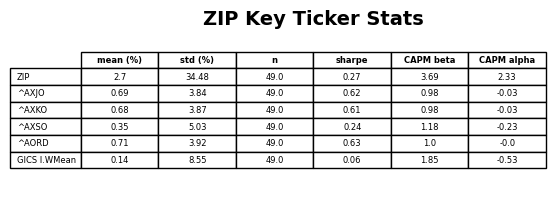

In [23]:
import matplotlib.pyplot as plt

# Assuming key_ticker_stats is already created from your DataFrame
key_ticker_stats = stats_df.loc[[TICKER, '^AXJO',
                                 '^AXKO', '^AXSO', '^AORD'] + ['GICS I.WMean' if 'industry' in comparable_tickers['type'] else 'GICS S.WMean']]

# Create the plot
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table in the plot
table = ax.table(cellText=key_ticker_stats.values,
                 colLabels=key_ticker_stats.columns,
                 rowLabels=key_ticker_stats.index,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')

# Set the title with bold font
plt.title(f"{TICKER} Key Ticker Stats", fontsize=14, fontweight='bold')

# Save the plot as an image
plt.savefig(
    f'../outputs/{TICKER}_key_ticker_stats_table.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [24]:
ticker_mv['Market Cap ($bn)'].values[0] / \
    weighted_mean_df['Market Cap ($bn)'].values[0]

3.797868760515984

In [25]:
correlation_df, period_of_interest_return_df = historical_corr(
    monthly_returns_df_dict, first_end_of_quarter, last_end_of_quarter)

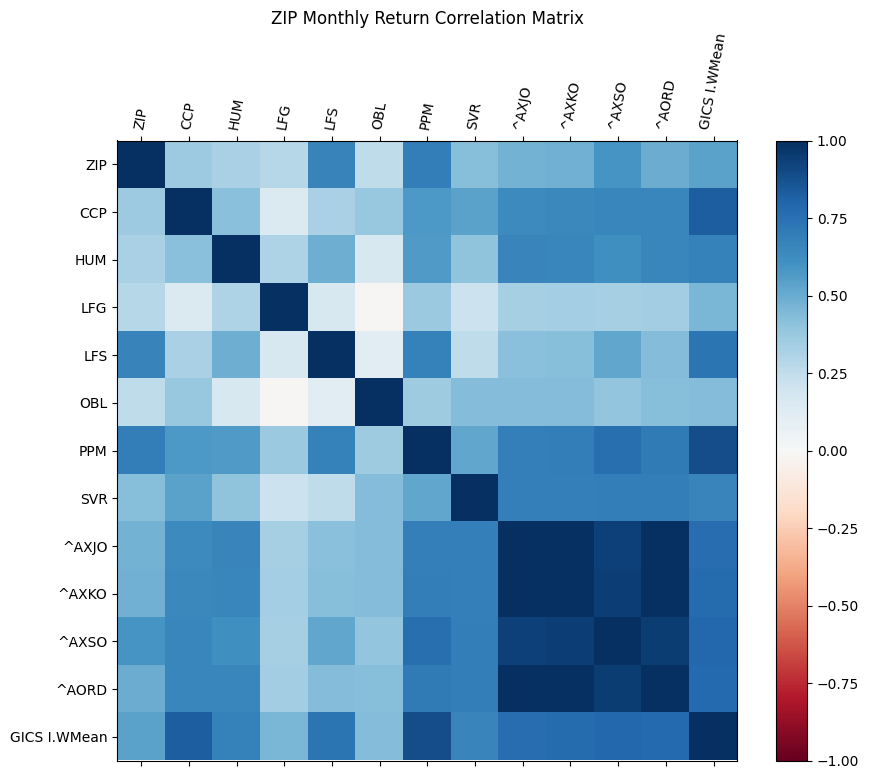

In [26]:
plot_correlation(correlation_df, ticker=TICKER)

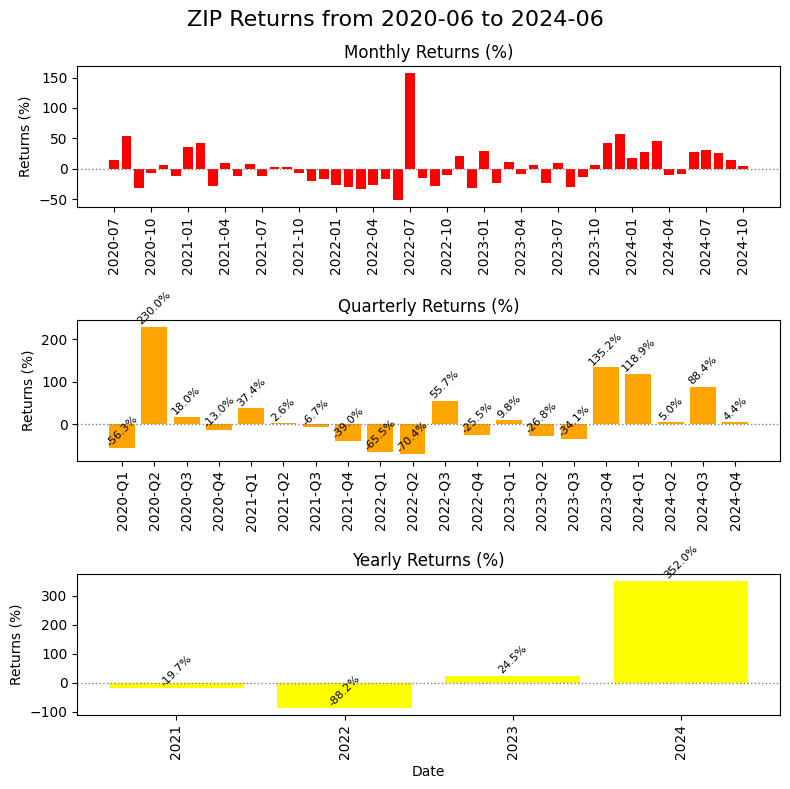

In [27]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict, 'ticker': TICKER,
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter})

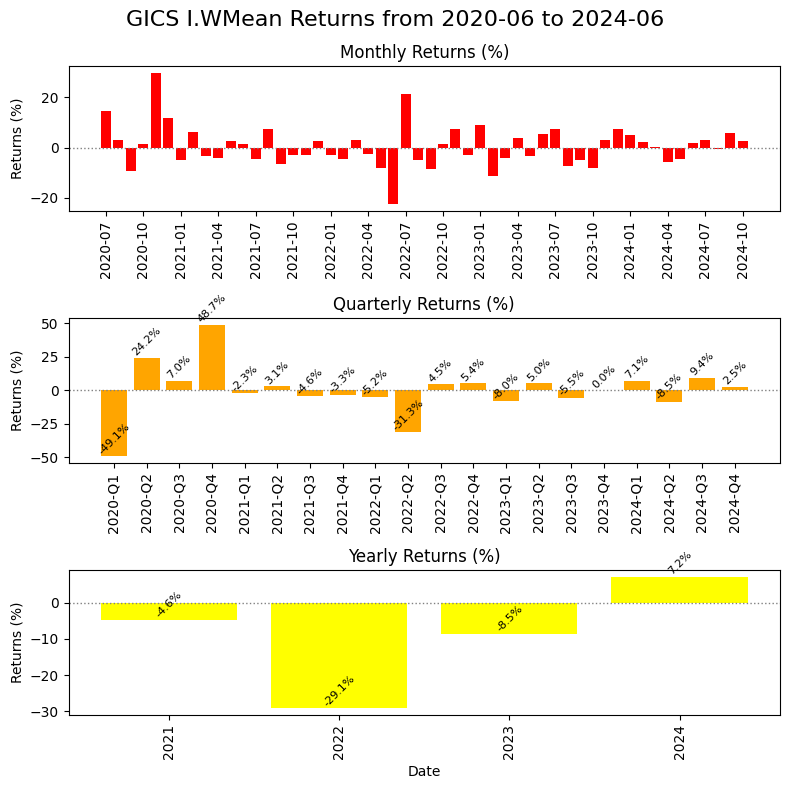

In [28]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict,
                'ticker': 'GICS I.WMean' if 'industry' in comparable_tickers['type'] else 'GICS S.WMean',
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter,
                'underlying_ticker': TICKER})

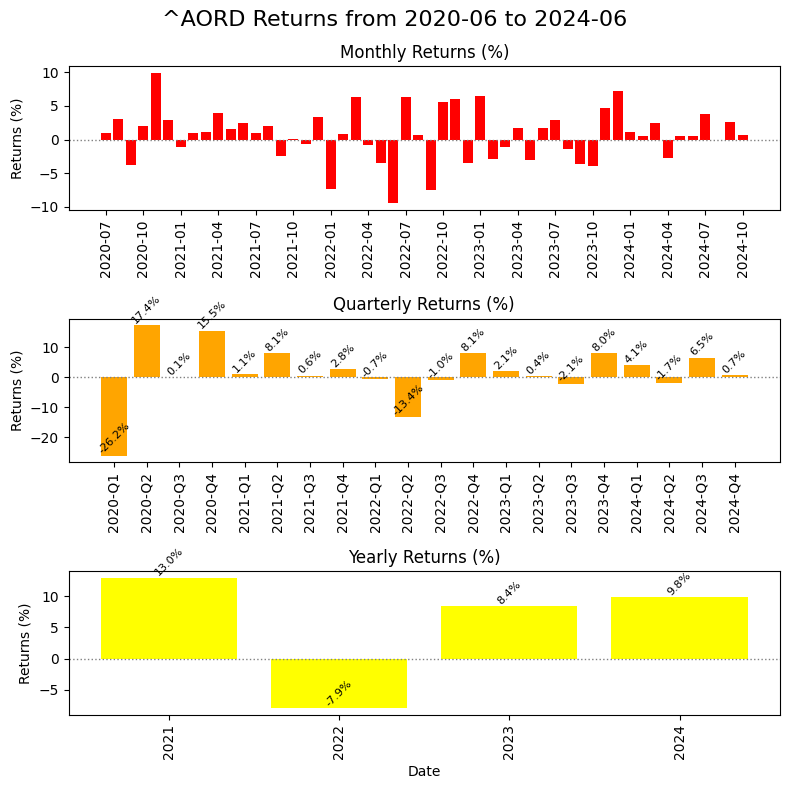

In [29]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict, 'ticker': '^AORD',
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter})

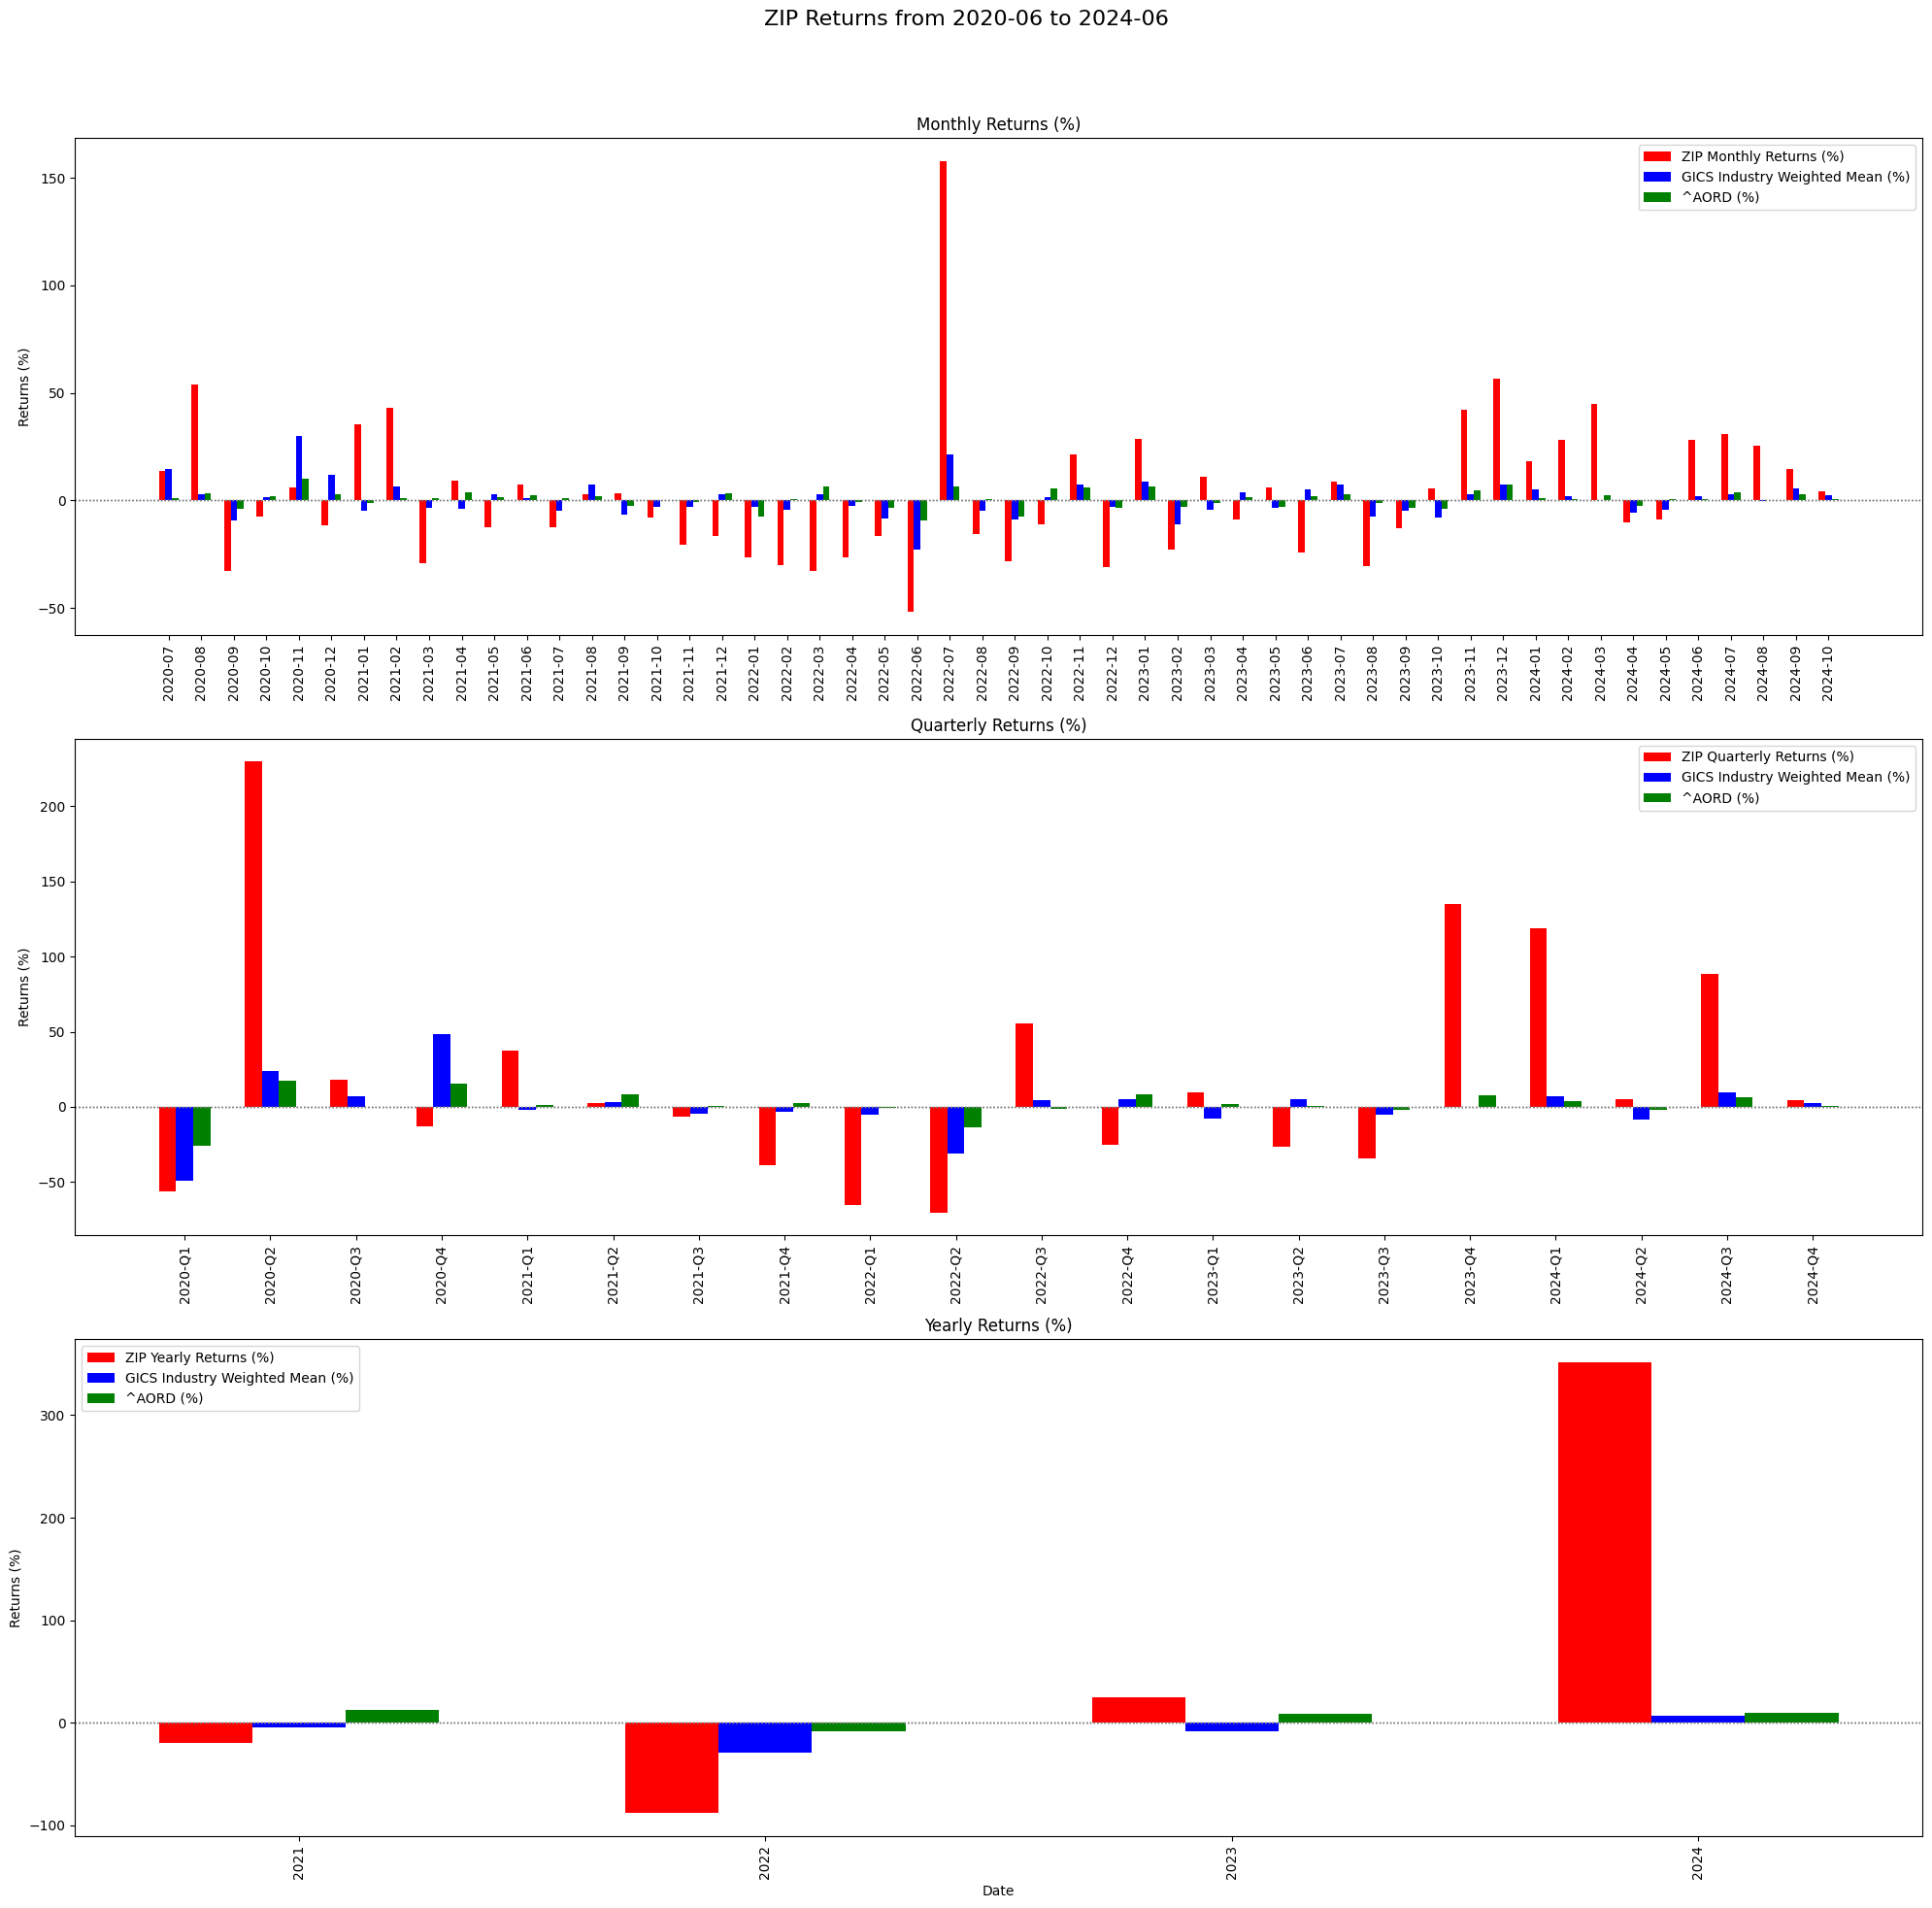

In [30]:
plot_returns_comparative(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                            'quarterly_returns_df_dict': quarterly_returns_df_dict,
                            'yearly_returns_df_dict': yearly_returns_df_dict, 'TICKER': TICKER,
                            'first_end_of_quarter': first_end_of_quarter,
                            'last_end_of_quarter': last_end_of_quarter,
                            'comparable_tickers': comparable_tickers})

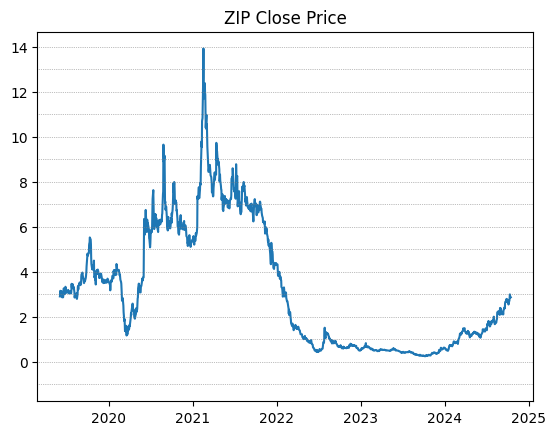

In [31]:
plot_close_price_with_dollar_lines(TICKER, historical_prices)

In [32]:
# Convert date to AEST directly using tz_convert, since the index is already timezone-aware
historical_dividends = historical_prices[TICKER]

# Reset index to move 'Date' from index to a column
historical_dividends = historical_dividends.reset_index()

# Ensure the 'Date' column is in datetime format
historical_dividends['Date'] = pd.to_datetime(historical_dividends['Date'])

# Convert the 'Date' column to AEST
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_convert(
    'Australia/Sydney')

# Now make it timezone unaware but still a timestamp
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_localize(
    None)

# Display the dividends greater than 0 with the adjusted 'Date' column
display(historical_dividends[historical_dividends['Dividends'] > 0][[
        'Date', 'Dividends']])

,Date,Dividends


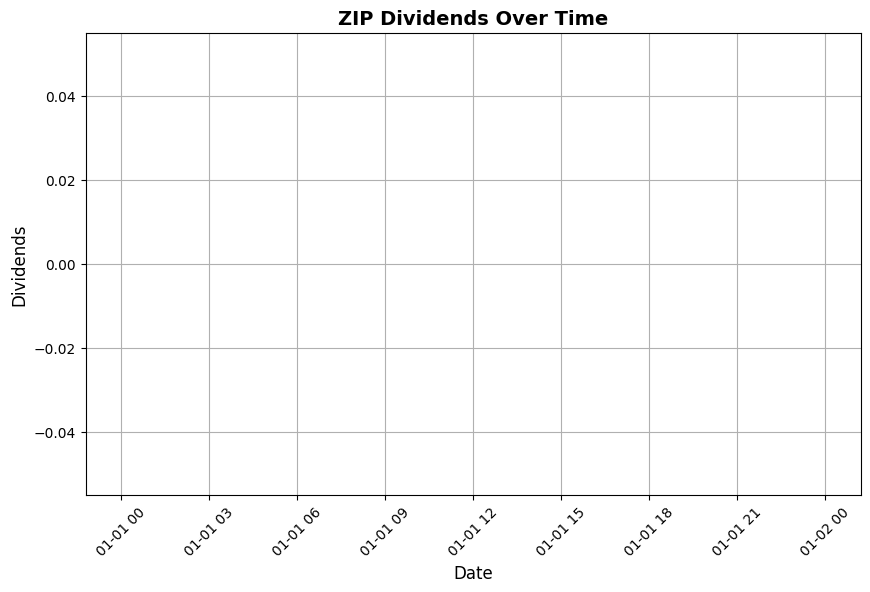

In [33]:
# Assuming historical_dividends is your DataFrame for a specific TICKER
# Convert the date to AEST
historical_dividends = historical_prices[TICKER]
# Reset index to move 'Date' from index to a column
historical_dividends = historical_dividends.reset_index()
historical_dividends['Date'] = pd.to_datetime(historical_dividends['Date'])
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_convert(
    'Australia/Sydney')
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_localize(
    None)

# Filter the data to include only the rows where Dividends are greater than 0
dividends_df = historical_dividends[historical_dividends['Dividends'] > 0][[
    'Date', 'Dividends']]

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))  # Create a plot with a defined size

# Plot Date vs Dividends
ax.plot(dividends_df['Date'], dividends_df['Dividends'],
        marker='o', linestyle='-', color='b')

# Set the title and labels
ax.set_title(f'{TICKER} Dividends Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Dividends', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid for better readability
ax.grid(True)

# Save the plot as an image if needed
plt.savefig(f'../outputs/{TICKER}_dividends_over_time.png',
            bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

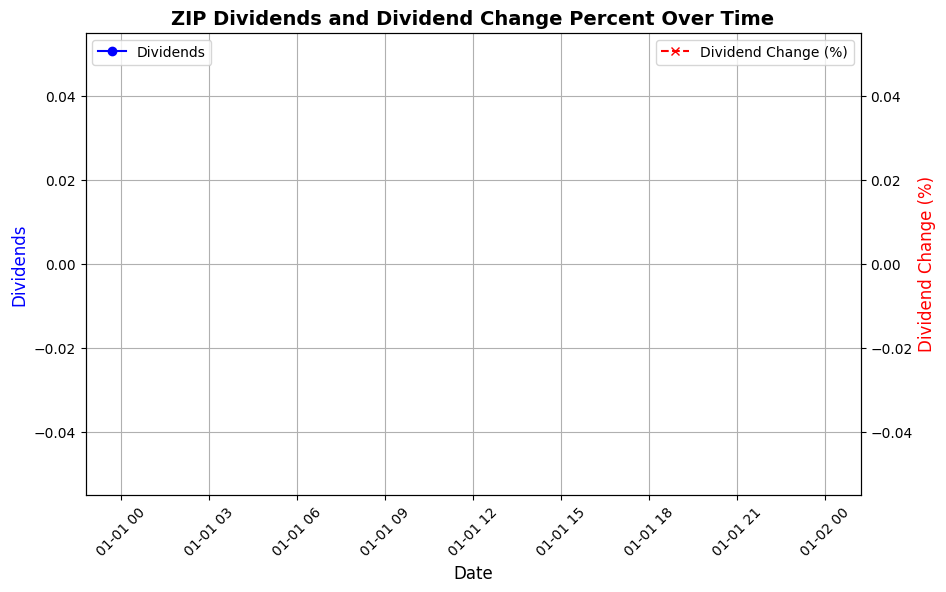

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming historical_dividends is your DataFrame for a specific TICKER
# Convert the date to AEST
historical_dividends = historical_prices[TICKER]

# Reset index to move 'Date' from index to a column
historical_dividends = historical_dividends.reset_index()
historical_dividends['Date'] = pd.to_datetime(historical_dividends['Date'])
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_convert(
    'Australia/Sydney')
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_localize(
    None)

# Filter the data to include only the rows where Dividends are greater than 0
dividends_df = historical_dividends[historical_dividends['Dividends'] > 0][[
    'Date', 'Dividends']]

# Calculate the percentage change in dividends
dividends_df['Dividend Change (%)'] = dividends_df['Dividends'].pct_change(
) * 100

# Plot the data
fig, ax1 = plt.subplots(figsize=(10, 6))  # Create a plot with a defined size

# Plot Date vs Dividends on the primary y-axis
ax1.plot(dividends_df['Date'], dividends_df['Dividends'],
         marker='o', linestyle='-', color='b', label='Dividends')

# Set the title and labels for the primary y-axis
ax1.set_title(f'{TICKER} Dividends and Dividend Change Percent Over Time',
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Dividends', fontsize=12, color='b')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid for better readability
ax1.grid(True)

# Create a secondary y-axis to plot the dividend change percentage
ax2 = ax1.twinx()

# Plot Date vs Dividend Change (%) on the secondary y-axis
ax2.plot(dividends_df['Date'], dividends_df['Dividend Change (%)'],
         marker='x', linestyle='--', color='r', label='Dividend Change (%)')

# Set the labels for the secondary y-axis
ax2.set_ylabel('Dividend Change (%)', fontsize=12, color='r')

# Add legends to distinguish between the two y-axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Annotate the percentage change values on the plot
for i, (date, change) in dividends_df[['Date', 'Dividend Change (%)']].dropna().iterrows():
    ax2.annotate(f'{change:.1f}%', xy=(date, change), xytext=(5, 5),
                 textcoords='offset points', fontsize=10, color='r')

# Save the plot as an image if needed
plt.savefig(
    f'../outputs/{TICKER}_dividends_and_change_over_time.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [35]:
# Convert date to AEST directly using tz_convert, since the index is already timezone-aware
historical_splits = historical_prices[TICKER]

# Reset index to move 'Date' from index to a column
historical_splits = historical_splits.reset_index()

# Ensure the 'Date' column is in datetime format
historical_splits['Date'] = pd.to_datetime(historical_splits['Date'])

# Convert the 'Date' column to AEST
historical_splits['Date'] = historical_splits['Date'].dt.tz_convert(
    'Australia/Sydney')

# Now make it timezone unaware but still a timestamp
historical_splits['Date'] = historical_splits['Date'].dt.tz_localize(
    None)

# Display the dividends greater than 0 with the adjusted 'Date' column
display(historical_splits[historical_splits['Stock Splits'] > 0][[
        'Date', 'Stock Splits']])

,Date,Stock Splits


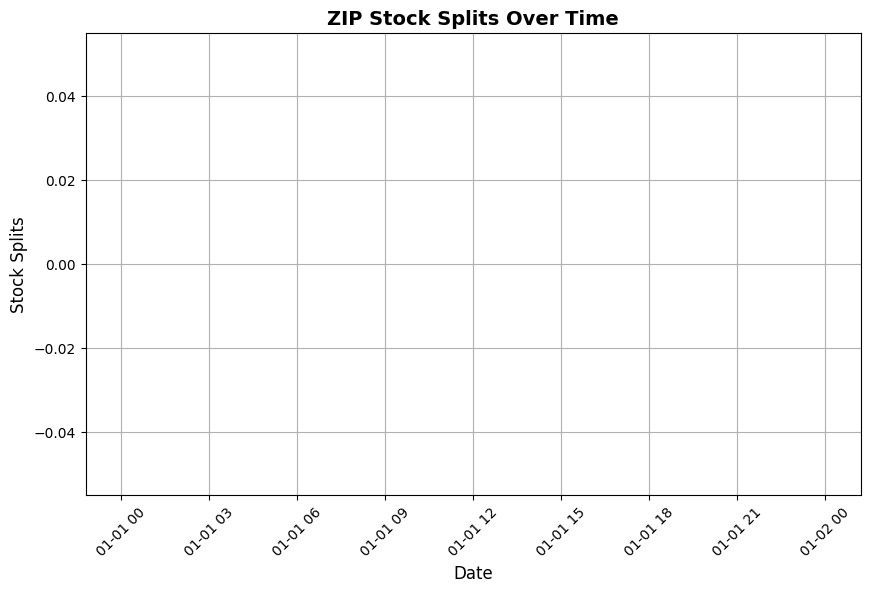

In [36]:
# Assuming historical_splits is your DataFrame for a specific TICKER
# Convert the date to AEST
historical_splits = historical_prices[TICKER]

# Reset index to move 'Date' from index to a column
historical_splits = historical_splits.reset_index()

# Ensure the 'Date' column is in datetime format
historical_splits['Date'] = pd.to_datetime(historical_splits['Date'])

# Convert the 'Date' column to AEST
historical_splits['Date'] = historical_splits['Date'].dt.tz_convert(
    'Australia/Sydney')

# Now make it timezone-unaware but still a timestamp
historical_splits['Date'] = historical_splits['Date'].dt.tz_localize(None)

# Filter the data to include only the rows where Stock Splits are greater than 0
splits_df = historical_splits[historical_splits['Stock Splits'] > 0][[
    'Date', 'Stock Splits']]

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))  # Create a plot with a defined size

# Plot Date vs Stock Splits
ax.plot(splits_df['Date'], splits_df['Stock Splits'],
        marker='o', linestyle='-', color='b')

# Set the title and labels
ax.set_title(f'{TICKER} Stock Splits Over Time',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Stock Splits', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid for better readability
ax.grid(True)

# Save the plot as an image if needed
plt.savefig(f'../outputs/{TICKER}_stock_splits_over_time.png',
            bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

- beta: need interest rate

In [37]:
# pdf = FPDF()

# # TITLE
# # Add a page
# pdf.add_page()
# # Set font for the title
# pdf.set_font("Arial", 'B', 16)  # Bold and size 16 for the title
# title = f"Stock Analysis of Ticker: {TICKER}"
# pdf.cell(200, 10, txt=title, ln=True, align='C')

# # Comparable Ticker Universe
# # Set font for the content
# pdf.set_font("Arial", 'B', size=12)
# pdf.cell(200, 10, txt=f"Comparable tickers universe", ln=True, align='L')
# pdf.set_font("Arial", size=10)
# text = f"{'same INDUSTRY of TOP500' if 'industry' in comparable_tickers['type'] else 'same SECTOR of MCAP$1BN+'}"
# pdf.cell(200, 10, txt=text, ln=True, align='L')

# # Retrieve and convert the Market Cap of the stock in question (from ticker_mv) to billions
# ticker_market_cap_billion = round(
#     ticker_mv.iloc[0]['Market Cap ($bn)'], 2)
# ticker_proportion_of_market = ticker_mv['Market Cap ($bn)'].values[0] / \
#     same_industry_tickers_mcap['Market Cap ($bn)'].sum()
# universe_market_value_billion = round(
#     same_industry_tickers_mcap['Market Cap ($bn)'].sum(), 2)
# pdf.cell(
#     200, 10, txt=f"{TICKER} has a market value of ${ticker_market_cap_billion}B and is {round(ticker_proportion_of_market, 2)} times the universe market value of ${universe_market_value_billion}B,", align='L')
# pdf.cell(
#     200, 10, txt=f"{round(ticker_mv['Market Cap ($bn)'].values[0]/weighted_mean_df['Market Cap ($bn)'].values[0],2)} times the average stock MCap in the universe.", align='L')
# pdf.ln()

# # KEY STATS
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Key Stats", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(
#     f'../outputs/{TICKER}_key_ticker_stats_table.png', x=10, y=None, w=125)

# # COMPARATIVE RETURNS PLOTS
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Comparative Returns Plot", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_comparative_returns.png', x=10, y=None, w=150)

# # TICKER RETURN CHART
# pdf.add_page()  # Add a new page for the plot
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Returns Chart", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_returns.png', x=10, y=None, w=100)

# # SECTOR/INDUSTRY WMEAN RETURNS CHART
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(
#     200, 10, txt=f"{TICKER} {'Industry' if 'industry' in comparable_tickers['type'] else 'Sector'} Weighted Mean Returns Chart", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_WMean_returns.png', x=10, y=None, w=100)

# # ^AORD CHART
# pdf.add_page()
# pdf.set_font("Arial", 'B', 12)
# pdf.cell(
#     200, 10, txt=f"{TICKER} ^AORD Chart", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/^AORD_returns.png', x=10, y=None, w=100)

# # CLOSE PRICE CHART
# pdf.add_page()  # Add a new page for the plot
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Close Price Chart", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_close_price.png', x=10, y=None, w=75)

# # DIVIDENDS
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Dividends", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_dividends_over_time.png', x=10, y=None, w=75)

# # APPENDIX
# pdf.add_page()  # Add a new page for the appendix
# # Set font for the title
# pdf.set_font("Arial", 'B', 12)  # Bold and size 16 for the title

# # APPENDIX TITLE
# title = f"Appendix"
# pdf.cell(200, 10, txt=title, ln=True, align='C')

# # CORRELATION
# pdf.set_font("Arial", 'B', 12)
# pdf.cell(200, 10, txt=f"{TICKER} Correlation Matrix Plot", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_correlation_matrix.png', x=10, y=None, w=140)

# # SPLITS
# pdf.set_font("Arial", 'B', 12)
# pdf.cell(200, 10, txt=f"{TICKER} Splits", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(
#     f'../outputs/{TICKER}_stock_splits_over_time.png', x=10, y=None, w=75)

# # INDUSTRY TICKER MCAP TABLE
# pdf.add_page()
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(
#     200, 10, txt=f"{TICKER} Same {'Industry' if 'industry' in comparable_tickers['type'] else 'Sector'} Ticker MCAP Table", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(
#     f'../outputs/{TICKER}_same_industry_tickers_mcap_table.png', x=10, y=None, w=75)

# # Save the PDF after adding the image
# pdf.output(f"../reports/{TICKER}_comparable_tickers_report_with_plot.pdf")

# Other Stats

In [38]:
object = yf.Ticker(f'{TICKER}.AX')

In [39]:
balance_sheet_row = [
    'Total Debt',  # total debt
    'Stockholders Equity',  # total shareholder equity.
    'Share Issued',  # n shares
    'Current Liabilities', # total current liabilities,
    'Current Assets', # total current assets

]
balance_sheet = object.balance_sheet.loc[balance_sheet_row]

In [40]:
cashflow_row = [
    'Free Cash Flow',  # cashflow
    'Interest Paid Supplemental Data',
    'Income Tax Paid Supplemental Data'
]

cashflows = object.cashflow.loc[cashflow_row]

In [41]:
financial_row = [
    'EBITDA',
    'EBIT',
    'Gross Profit',  # profit
    'Operating Expense',
    
    'Net Income', # net income
    'Total Revenue',  # revenue
    'Interest Expense',  # interest expense
]

financials = object.financials.loc[financial_row]

In [42]:
stock_fundementals = pd.concat([balance_sheet, cashflows, financials]).T
# sort the rows by index
stock_fundementals = stock_fundementals.sort_index()
# change index to datetime and only keep dates
stock_fundementals.index = pd.to_datetime(stock_fundementals.index).date

In [43]:
print(object.dividends)

Series([], Name: Dividends, dtype: float64)


In [44]:
stock_fundementals

,Total Debt,Stockholders Equity,Share Issued,Current Liabilities,Current Assets,Free Cash Flow,Interest Paid Supplemental Data,Income Tax Paid Supplemental Data,EBITDA,EBIT,Gross Profit,Operating Expense,Net Income,Total Revenue,Interest Expense
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,2135494000.0,1168376000.0,562136000.0,73453000.0,364427000.0,30831000.0,57677000.0,NaN,-605613000.0,-654811000.0,196547000.0,414456000.0,-658774000.0,397068000.0,69203000.0
2022-06-30,2765864000.0,436734000.0,687936000.0,156362000.0,376394000.0,-781932000.0,72404000.0,NaN,-927203000.0,-995848000.0,229635000.0,508912000.0,-1105093000.0,620003000.0,109557000.0
2023-06-30,2936093000.0,234340000.0,824647000.0,222445000.0,370266000.0,-249595000.0,161529000.0,NaN,-34919000.0,-98351000.0,401209000.0,397605000.0,-377015000.0,693207000.0,273940000.0
2024-06-30,2420234000.0,398533000.0,1126660000.0,277004000.0,458341000.0,255055000.0,229428000.0,3008000.0,359856000.0,295437000.0,574645000.0,348918000.0,3657000.0,867978000.0,270333000.0


In [45]:
stock_fundementals['Net Profit'] = stock_fundementals['Gross Profit'] - stock_fundementals['Operating Expense'] - stock_fundementals['Interest Paid Supplemental Data'] - stock_fundementals['Income Tax Paid Supplemental Data']

# get the mean of every two rows
def get_avg_shareholder_equity(series):
    out = [np.nan]
    series = series.copy()
    series.fillna(series.values[1], inplace=True)
    for i in range(1, len(series)):
        out.append((series[i] + series[i-1]) / 2)
    return out

stock_fundementals['Average Shareholder Equity'] = get_avg_shareholder_equity(stock_fundementals['Stockholders Equity'])
stock_fundementals['Total Asset'] = stock_fundementals['Current Liabilities'] + stock_fundementals['Stockholders Equity']

In [46]:
stock_fundementals_dates = stock_fundementals.index
ticker_prices = deepcopy(historical_prices[TICKER])
ticker_prices.index = pd.to_datetime(ticker_prices.index).date

In [47]:
def find_last_close_price(ticker_prices, stock_fundementals_dates):
    """ Find the close price on the day of the fundementals, or backtrack to find closest earlier price """

    close_price_dict = {}

    for date in stock_fundementals_dates:
        if date in ticker_prices.index:
            close_price = ticker_prices.loc[date]['Close']
            close_price_dict[date] = close_price
        else:
            old_date = date
            while date not in ticker_prices.index:
                date = date - timedelta(days=1)
            close_price = ticker_prices.loc[date]['Close']
            close_price_dict[old_date] = close_price
    
    return pd.DataFrame(close_price_dict, index=['Last Close Price']).T

In [48]:
last_close_price_df = find_last_close_price(ticker_prices, stock_fundementals_dates)

In [49]:
stock_fundementals = stock_fundementals.merge(last_close_price_df, left_index=True, right_index=True)

In [50]:
stock_fundementals

,Total Debt,Stockholders Equity,Share Issued,Current Liabilities,Current Assets,Free Cash Flow,Interest Paid Supplemental Data,Income Tax Paid Supplemental Data,EBITDA,EBIT,Gross Profit,Operating Expense,Net Income,Total Revenue,Interest Expense,Net Profit,Average Shareholder Equity,Total Asset,Last Close Price
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.23
2021-06-30,2135494000.0,1168376000.0,562136000.0,73453000.0,364427000.0,30831000.0,57677000.0,NaN,-605613000.0,-654811000.0,196547000.0,414456000.0,-658774000.0,397068000.0,69203000.0,NaN,1.168376e+09,1241829000.0,7.57
2022-06-30,2765864000.0,436734000.0,687936000.0,156362000.0,376394000.0,-781932000.0,72404000.0,NaN,-927203000.0,-995848000.0,229635000.0,508912000.0,-1105093000.0,620003000.0,109557000.0,NaN,8.025550e+08,593096000.0,0.44
2023-06-30,2936093000.0,234340000.0,824647000.0,222445000.0,370266000.0,-249595000.0,161529000.0,NaN,-34919000.0,-98351000.0,401209000.0,397605000.0,-377015000.0,693207000.0,273940000.0,NaN,3.355370e+08,456785000.0,0.41
2024-06-30,2420234000.0,398533000.0,1126660000.0,277004000.0,458341000.0,255055000.0,229428000.0,3008000.0,359856000.0,295437000.0,574645000.0,348918000.0,3657000.0,867978000.0,270333000.0,-6709000.0,3.164365e+08,675537000.0,1.46


In [51]:
stock_fundementals['Net Profit Margin'] = stock_fundementals['Net Profit'] / stock_fundementals['Total Revenue']
stock_fundementals['Net Income Margin'] = stock_fundementals['Net Income'] / stock_fundementals['Total Revenue']
stock_fundementals['RoE'] = stock_fundementals['Net Profit'] / stock_fundementals['Average Shareholder Equity']
stock_fundementals['RoA'] = stock_fundementals['Net Profit'] / stock_fundementals['Total Asset']

stock_fundementals['P/E'] = stock_fundementals['Last Close Price'] / (stock_fundementals['Net Income']/stock_fundementals['Share Issued'])
stock_fundementals['P/B'] = stock_fundementals['Last Close Price'] / (stock_fundementals['Stockholders Equity']/stock_fundementals['Share Issued'])

# dividend - match with nearest 财报

stock_fundementals['D/E'] = stock_fundementals['Total Debt'] / stock_fundementals['Stockholders Equity']
stock_fundementals['Current Ratio'] = stock_fundementals['Current Assets'] / stock_fundementals['Current Liabilities']
stock_fundementals['Interest Coverage Ratio'] = stock_fundementals['EBIT'] / stock_fundementals['Interest Paid Supplemental Data']

In [52]:
stock_fundementals

,Total Debt,Stockholders Equity,Share Issued,Current Liabilities,Current Assets,Free Cash Flow,Interest Paid Supplemental Data,Income Tax Paid Supplemental Data,EBITDA,EBIT,...,Last Close Price,Net Profit Margin,Net Income Margin,RoE,RoA,P/E,P/B,D/E,Current Ratio,Interest Coverage Ratio
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,2135494000.0,1168376000.0,562136000.0,73453000.0,364427000.0,30831000.0,57677000.0,NaN,-605613000.0,-654811000.0,...,7.57,NaN,-1.659096,NaN,NaN,-6.459529,3.642123,1.827746,4.961363,-11.35307
2022-06-30,2765864000.0,436734000.0,687936000.0,156362000.0,376394000.0,-781932000.0,72404000.0,NaN,-927203000.0,-995848000.0,...,0.44,NaN,-1.782399,NaN,NaN,-0.273906,0.693081,6.333063,2.407196,-13.754047
2023-06-30,2936093000.0,234340000.0,824647000.0,222445000.0,370266000.0,-249595000.0,161529000.0,NaN,-34919000.0,-98351000.0,...,0.41,NaN,-0.543871,NaN,NaN,-0.896795,1.442798,12.529201,1.664528,-0.608875
2024-06-30,2420234000.0,398533000.0,1126660000.0,277004000.0,458341000.0,255055000.0,229428000.0,3008000.0,359856000.0,295437000.0,...,1.46,-0.007729,0.004213,-0.021202,-0.009931,449.801379,4.127447,6.072857,1.654637,1.287711
